In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

DATA = 'tests/mpi_server.csv'

data = pd.read_csv(DATA, header=0)

data.columns

Index(['group', 'split_size', 'N', 'ntasks-per-node', 'compression_time',
       'decompression_time', 'diff'],
      dtype='object')

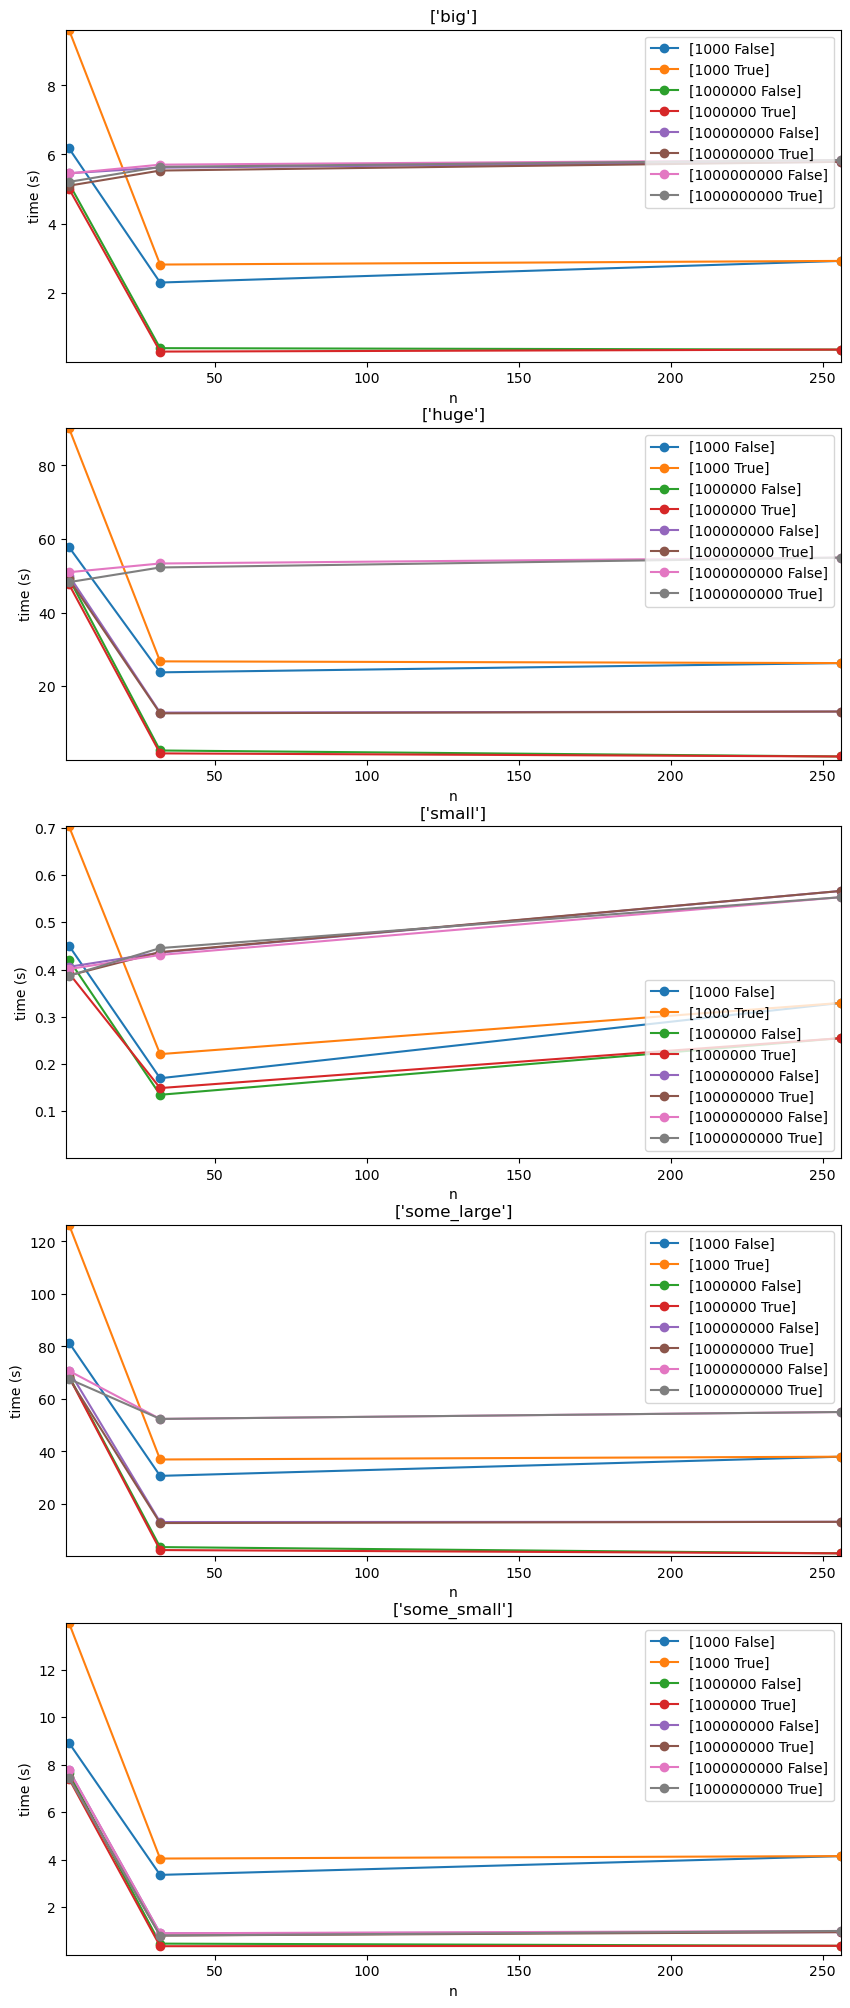

In [11]:
import matplotlib.axis
import matplotlib.figure


data_ = data.copy()
# No errors
assert (data_['diff'] == 'OK').all()

TYPE = 'mpi' if 'N' in data_.columns else 'ff' if 'n_threads' in data_.columns else 'seq'

# N_GROUPS = data_['group'].unique().size
# N_SPLITS = data_['split_size'].unique().size

diff_cats = ['group']
color_cats = ['split_size']

if TYPE == 'mpi':
  data_['bynode'] = ~data_['ntasks-per-node'].isna()
  del data_['ntasks-per-node']
  data_['n'] = data_['N']
  del data_['N']
  tmp = data_[(data_['n'] == 256)].copy()
  tmp.loc[:, 'bynode'] = True
  data_ = pd.concat([data_, tmp])
  color_cats += ['bynode']
elif TYPE == 'ff':
  data_['n'] = data_['n_threads']
  del data_['n_threads']

plots = data_.groupby(diff_cats)[diff_cats].first().reset_index(drop=True)
num_plots = plots.size

fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))
for i, p in enumerate(plots.values):
  local_data = data_.loc[(data_[diff_cats] == p).all(axis=1)]
  ax: matplotlib.axes.Axes = axs[i]
  ax.set_xlabel('n')
  ax.set_ylabel('time (s)')
  ax.set_xlim(1, local_data['n'].max())
  ax.set_ylim(1e-3, local_data['compression_time'].max())
  ax.set_title(f'{p}')
  colors = local_data.groupby(color_cats)[color_cats].first().reset_index(drop=True)
  num_colors = colors.size
  for j, c in enumerate(colors.values):
    local_data_ = local_data.loc[(local_data[color_cats] == c).all(axis=1)]
    ax.plot(local_data_['n'], local_data_['compression_time'], label=f'{c}', marker='o', linestyle='-', color=f'C{j}')
    # ax.plot(local_data_['n'], local_data_['decompression_time'], label=f'{c}', marker='o', linestyle='dashed', color=f'C{j}')
  ax.legend()

  